In [108]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
from sklearn import model_selection, cross_validation
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [109]:
train_csv = pd.read_csv('train_cap2018.csv')

In [110]:
# get the number of missing data points per column
missing_values_count = train_csv.isnull().sum()

#percent of the data missing for columns containing missing values
missing_values_count[missing_values_count != 0] / train_csv.shape[0] *100

MATTR    80.010985
MSTTR    79.223728
dtype: float64

In [111]:
train_cols = train_csv.columns.tolist()
#we drop high missing values columns
train_cols.remove("MATTR")
train_cols.remove("MSTTR")
train_cols.remove("text")
train_cols.remove("fulltext")
train_cols.remove("level1")
target = "level1"

Y = train_csv[target].astype('str')
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

In [124]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_csv[train_cols], label_encoded_y, test_size=test_size, random_state=seed, stratify=label_encoded_y)
# fit model no training data

parameters = {'objective':'multi:softprob',
              'n_jobs':6,
              'n_thread': 4,
              'num_class': 6,
              'learning_rate': 0.01, #so called `eta` value
              'max_depth': 8,
              'min_child_weight': 11,
              'silent': [1],
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'n_estimators': 1000, #number of trees, change it to 1000 for better results
              'seed': 1337}

xgtrain = xgboost.DMatrix(X_train, label=y_train)
model = xgboost.XGBClassifier(**parameters)
xgb_param = model.get_xgb_params()
#do cross validation
print ('Start cross validation')
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['merror'],
     early_stopping_rounds=50, stratified=True, seed=1301)

print('Best number of trees = {}'.format(cvresult.shape[0]))
model.set_params(n_estimators=cvresult.shape[0])
print('Fit on the trainingsdata')
model.fit(X_train, y_train, eval_metric='merror')

Start cross validation
Best number of trees = 888
Fit on the trainingsdata


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=11, missing=None, n_estimators=888,
       n_jobs=6, n_thread=4, nthread=None, num_class=6,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=[1],
       subsample=0.7)

In [125]:
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=11, missing=None, n_estimators=888,
       n_jobs=6, n_thread=4, nthread=None, num_class=6,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=[1],
       subsample=0.7)
Accuracy: 75.22%


/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [126]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[3200,  419,   92,   34,    4,    0],
       [ 403, 1791,  314,   29,    0,    0],
       [  64,  276, 1276,  150,   11,    0],
       [  16,   36,  210,  472,   37,    0],
       [   3,    5,   16,   97,   41,    0],
       [   1,    0,    1,   10,    5,    0]])

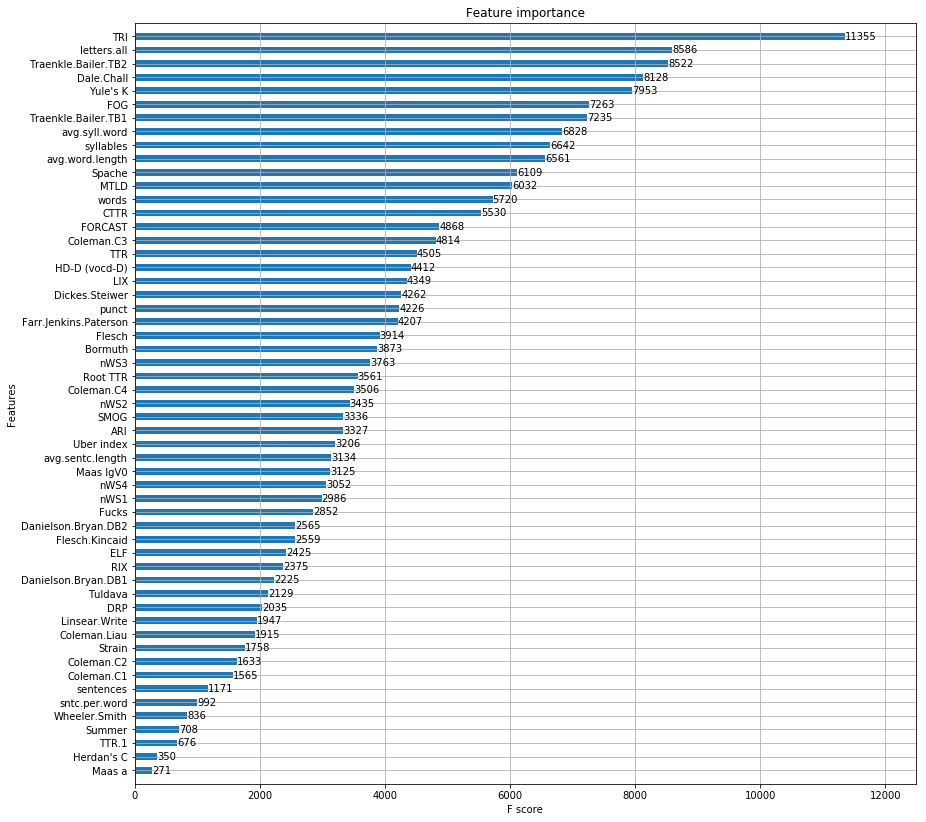

In [135]:
from xgboost import plot_importance
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (14,14)
plot_importance(model, height=0.5)